# Loan Approval

## Imports

In [92]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from pyod.models.knn import KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [93]:
# Utility: one-hot encode a single column with drop_first=True
def one_hot_encode_column(df, column):
    """One-hot encode `column` in `df`, drop the first category,
    and ensure output columns are 0/1 integers (not booleans).
    Returns a new DataFrame with the original column dropped and dummy
    columns concatenated. If the column is not present, returns df unchanged.
    """
    if column not in df.columns:
        return df

    # Use pandas get_dummies with drop_first. This yields numeric 0/1 by default,
    # but we explicitly cast to int to ensure no boolean dtype remains.
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
    if not dummies.empty:
        dummies = dummies.astype(int)

    # Drop the original column and concat dummies (if any)
    df = df.drop(columns=[column])
    if not dummies.empty:
        df = pd.concat([df, dummies], axis=1)

    return df

In [94]:
def visualize_outliers(method_name, preds, title_suffix=''):
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=preds, cmap='coolwarm', edgecolors='k')
    plt.title(f'{method_name} - {title_suffix}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Anomaly (1=outlier)')
    plt.show()


## Data Load

In [95]:
df = pd.read_csv('Loan_Prediction_Dataset.csv')

## Data Preprocessing

In [96]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [98]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [99]:
df.drop(columns=['Loan_ID'], inplace=True)

### Feature/Target Split

In [100]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

### Train/Test Split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Imputation

In [102]:
#function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    

print("Missing values in training set:")
print(missing_values_table(X_train))

print("\nMissing values in test set:")
print(missing_values_table(X_test))

Missing values in training set:
                  Missing Values  % of Total Values
Credit_History                40                8.1
Self_Employed                 24                4.9
LoanAmount                    16                3.3
Gender                        12                2.4
Loan_Amount_Term              12                2.4
Dependents                    11                2.2
Married                        1                0.2

Missing values in test set:
                  Missing Values  % of Total Values
Credit_History                10                8.1
Self_Employed                  8                6.5
LoanAmount                     6                4.9
Dependents                     4                3.3
Married                        2                1.6
Loan_Amount_Term               2                1.6
Gender                         1                0.8


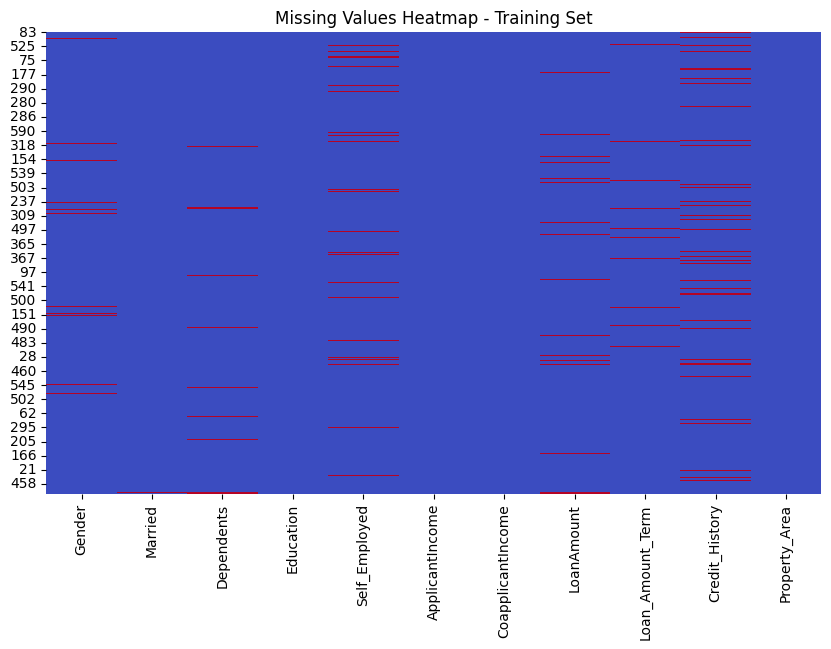

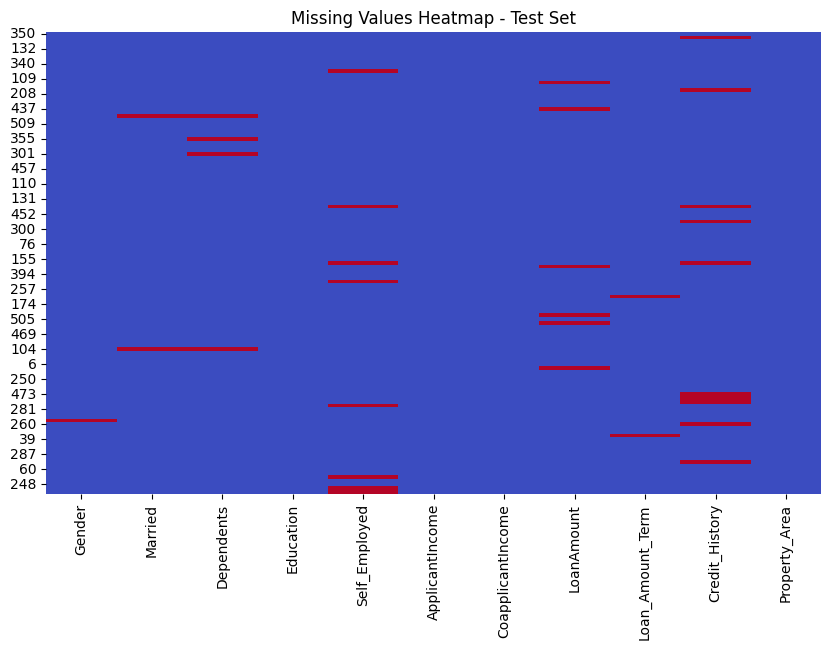

In [103]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_train.isnull(), cbar=False, cmap="coolwarm")
plt.title("Missing Values Heatmap - Training Set")
plt.show()

# Visualize missing values in the test set
plt.figure(figsize=(10, 6))
sns.heatmap(X_test.isnull(), cbar=False, cmap="coolwarm")
plt.title("Missing Values Heatmap - Test Set")
plt.show()

#### Credit History

In [104]:
X_train['Credit_History'] = X_train['Credit_History'].fillna(X_train['Credit_History'].mode()[0])
X_test['Credit_History'] = X_test['Credit_History'].fillna(X_train['Credit_History'].mode()[0])

#### Self-Employed

In [105]:
X_train[['Self_Employed']] = X_train[['Self_Employed']].fillna(X_train['Self_Employed'].mode()[0])
X_test[['Self_Employed']] = X_test[['Self_Employed']].fillna(X_train['Self_Employed'].mode()[0])

#### Loan Amount

Text(0.5, 1.0, 'Loan Amount Distribution Before and After Mean Imputation')

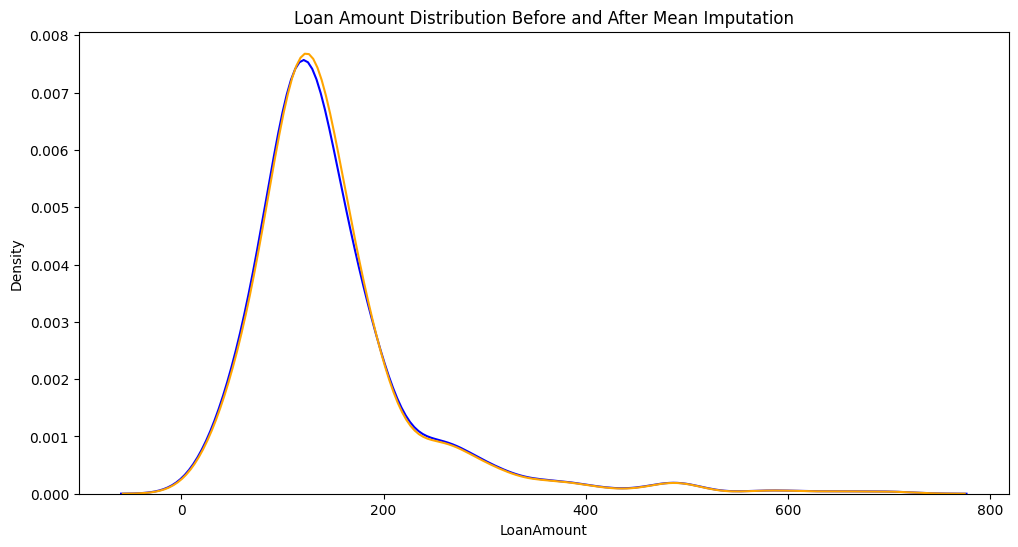

In [106]:
plt.figure(figsize=(12, 6))
sns.kdeplot(X_train['LoanAmount'].dropna(), label='Before Imputation', color='blue')
sns.kdeplot(X_train['LoanAmount'].fillna(X_train['LoanAmount'].mean()), label='After Imputation', color='orange')
plt.title('Loan Amount Distribution Before and After Mean Imputation')

In [107]:
X_train['LoanAmount'] = X_train['LoanAmount'].fillna(X_train['LoanAmount'].mean())
X_test['LoanAmount'] = X_test['LoanAmount'].fillna(X_train['LoanAmount'].mean())

#### Gender

In [108]:
X_train['Gender'] = X_train['Gender'].fillna(X_train['Gender'].mode()[0])
X_test['Gender'] = X_test['Gender'].fillna(X_train['Gender'].mode()[0]) 

#### Loan Amount Term

In [109]:
knn_imputer = KNNImputer(n_neighbors=5)
X_train[['Loan_Amount_Term']] = knn_imputer.fit_transform(X_train[['Loan_Amount_Term']])
X_test[['Loan_Amount_Term']] = knn_imputer.transform(X_test[['Loan_Amount_Term']])

#### Dependents

In [110]:
X_train['Dependents'].value_counts()

Dependents
0     282
1      79
2      78
3+     41
Name: count, dtype: int64

In [111]:
X_train['Dependents'] = X_train['Dependents'].fillna(X_train['Dependents'].mode()[0])
X_test['Dependents'] = X_test['Dependents'].fillna(X_train['Dependents'].mode()[0]) 

#### Married

In [112]:
X_train['Married'] = X_train['Married'].fillna(X_train['Married'].mode()[0])
X_test['Married'] = X_test['Married'].fillna(X_train['Married'].mode()[0])

In [113]:
print("Missing values in training set:")
print(missing_values_table(X_train))

print("\nMissing values in test set:")
print(missing_values_table(X_test))

Missing values in training set:
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Missing values in test set:
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


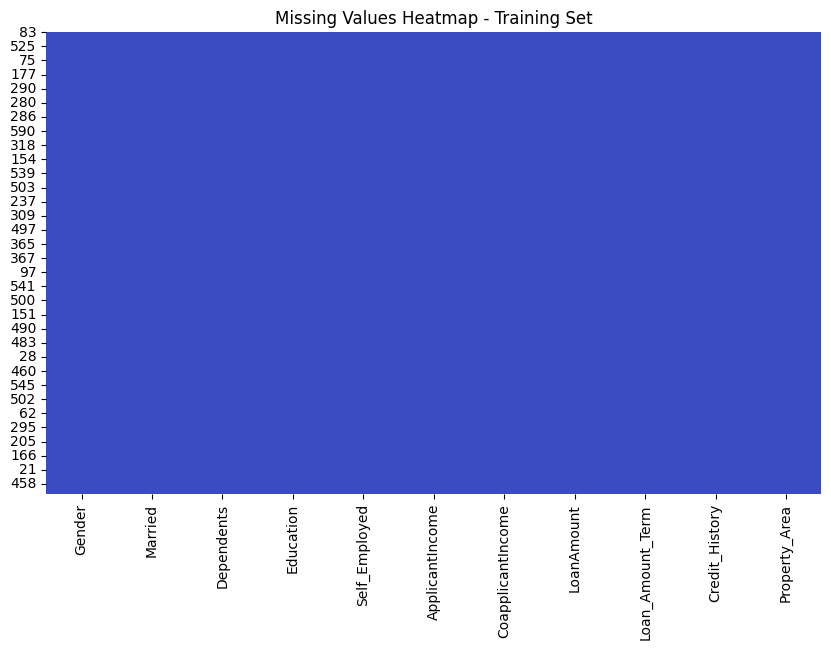

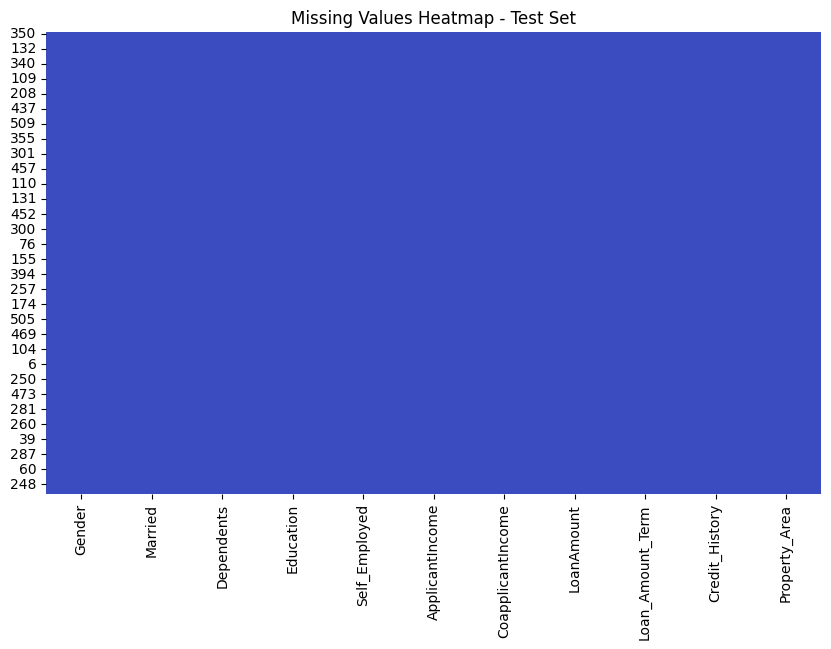

In [114]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_train.isnull(), cbar=False, cmap="coolwarm")
plt.title("Missing Values Heatmap - Training Set")
plt.show()

# Visualize missing values in the test set
plt.figure(figsize=(10, 6))
sns.heatmap(X_test.isnull(), cbar=False, cmap="coolwarm")
plt.title("Missing Values Heatmap - Test Set")
plt.show()

### Encoding

In [115]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
83,Male,Yes,0,Graduate,No,6000,2250.0,265.0,360.0,1.0,Semiurban
90,Male,Yes,0,Graduate,No,2958,2900.0,131.0,360.0,1.0,Semiurban
227,Male,Yes,2,Graduate,No,6250,1695.0,210.0,360.0,1.0,Semiurban
482,Male,Yes,0,Graduate,No,2083,3150.0,128.0,360.0,1.0,Semiurban
464,Male,No,0,Graduate,No,4166,0.0,98.0,360.0,0.0,Semiurban


#### Gender

In [116]:
X_train = one_hot_encode_column(X_train, 'Gender')
X_test = one_hot_encode_column(X_test, 'Gender')

#### Married

In [117]:
X_train = one_hot_encode_column(X_train, 'Married')
X_test = one_hot_encode_column(X_test, 'Married')

#### Dependents

In [118]:
X_train['Dependents'] = X_train['Dependents'].replace('3+', 3).astype(int)
X_test['Dependents'] = X_test['Dependents'].replace('3+', 3).astype(int)

#### Education

In [119]:
X_train = one_hot_encode_column(X_train, 'Education')
X_test = one_hot_encode_column(X_test, 'Education')

#### Self-Employed

In [120]:
X_train = one_hot_encode_column(X_train, 'Self_Employed')
X_test = one_hot_encode_column(X_test, 'Self_Employed')

#### Property Area

In [121]:
X_train = one_hot_encode_column(X_train, 'Property_Area')
X_test = one_hot_encode_column(X_test, 'Property_Area')

## Feature Engineering

In [122]:
def add_engineered_features(df):
    # Total Income
    df["Total_Income"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
    
    # Log transforms (handle any zeros safely)
    df["LoanAmount_log"] = np.log1p(df["LoanAmount"])
    df["TotalIncome_log"] = np.log1p(df["Total_Income"])
    
    # EMI (Installment per month)
    df["EMI"] = df["LoanAmount"] / df["Loan_Amount_Term"]
    
    # Balance Income after paying EMI
    df["BalanceIncome"] = df["Total_Income"] - (df["EMI"] * 1000)
    
    # Loan to Income Ratio
    df["Loan_Income_Ratio"] = df["LoanAmount"] / df["Total_Income"]
    
    return df

In [123]:
X_train = add_engineered_features(X_train.copy())
X_test = add_engineered_features(X_test.copy())

## Scaling

In [124]:
scaler = StandardScaler()
X_train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term','Total_Income', 'Loan_Income_Ratio', 'LoanAmount_log', 'TotalIncome_log', 'EMI', 'BalanceIncome']] = scaler.fit_transform(
    X_train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income', 'Loan_Income_Ratio', 'LoanAmount_log', 'TotalIncome_log', 'EMI', 'BalanceIncome']])
X_test[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income', 'Loan_Income_Ratio', 'LoanAmount_log', 'TotalIncome_log', 'EMI', 'BalanceIncome']] = scaler.transform(
    X_test[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income', 'Loan_Income_Ratio', 'LoanAmount_log', 'TotalIncome_log', 'EMI', 'BalanceIncome']])

## Anomaly Detection

In [125]:
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(X_train)

### Isolation Forest

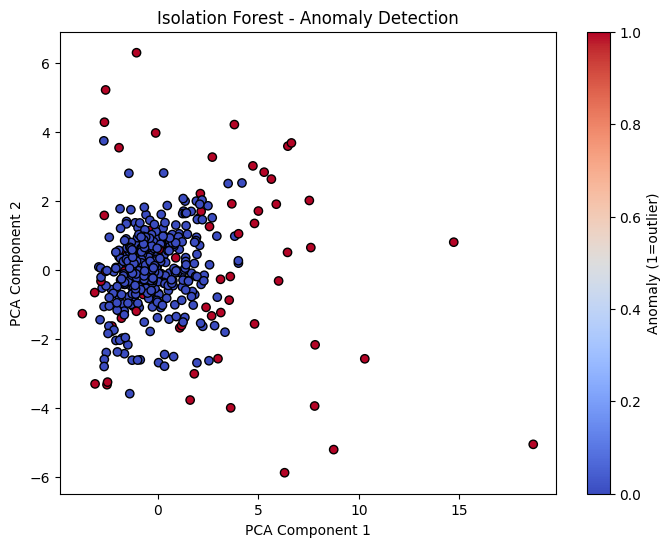

In [126]:
iso = IsolationForest(
    n_estimators=200,
    contamination='auto',
    random_state=42
)

iso.fit(X_train)
iso_preds = (iso.predict(X_train) == -1).astype(int)

visualize_outliers('Isolation Forest', iso_preds, 'Anomaly Detection')

### Distance-Based KNN

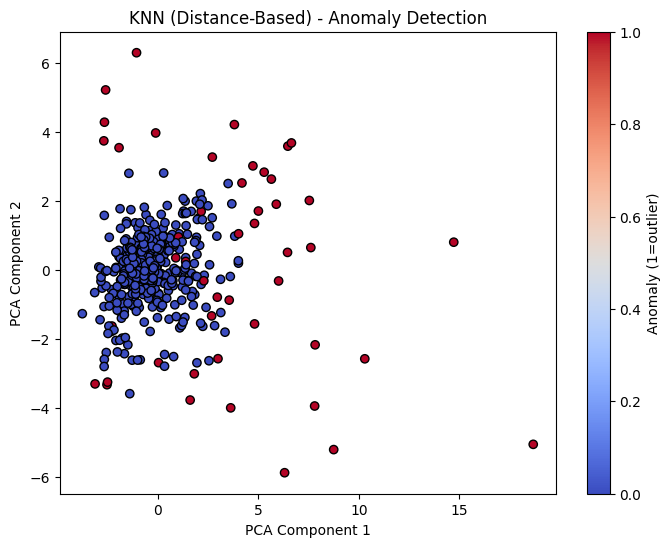

In [127]:
knn = KNN(
    n_neighbors=10,
    method='largest',
    contamination=0.1
)

knn.fit(X_train)
knn_preds = knn.labels_

visualize_outliers('KNN (Distance-Based)', knn_preds, 'Anomaly Detection')

### Density-Based KNN

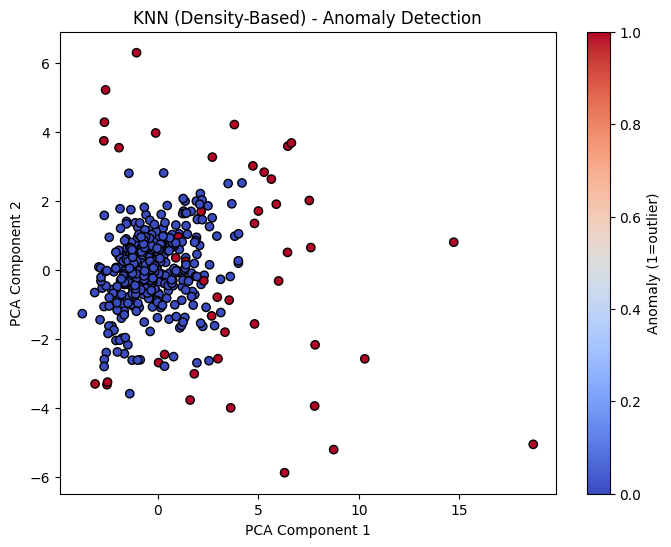

In [128]:
knn_density = KNN(
    n_neighbors=10,
    method='mean',
    contamination=0.1
)

knn_density.fit(X_train)
knn_density_preds = knn_density.labels_

visualize_outliers('KNN (Density-Based)', knn_density_preds, 'Anomaly Detection')

We will drop rows that were flagged as anomalies by 2+ anomaly detection methods.

In [129]:
combined_preds = pd.DataFrame({
    'iso': iso_preds,
    'knn': knn_preds,
    'knn_density': knn_density_preds
}, index=X_train.index)

combined_preds['anomaly_sum'] = combined_preds.sum(axis=1)
rows_to_drop = combined_preds[combined_preds['anomaly_sum'] >= 2].index

In [130]:
# Drop anomalies from training features
X_train_clean = X_train.drop(index=rows_to_drop)

# Drop anomalies from each target
y_train_clean = y_train.drop(index=rows_to_drop)

print("Original training size:", len(X_train))
print("New clean training size:", len(X_train_clean))
print("Rows removed:", len(rows_to_drop))
print(f"Percentage removed: {len(rows_to_drop) / len(X_train):.2%}")

Original training size: 491
New clean training size: 443
Rows removed: 48
Percentage removed: 9.78%


## Model Training

### Logistic Regression

In [131]:
regressor = LogisticRegression()
regressor.fit(X_train_clean, y_train_clean)

y_pred_logreg = regressor.predict(X_test)

#### Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           N       0.90      0.44      0.59        43
           Y       0.76      0.97      0.86        80

    accuracy                           0.79       123
   macro avg       0.83      0.71      0.73       123
weighted avg       0.81      0.79      0.77       123



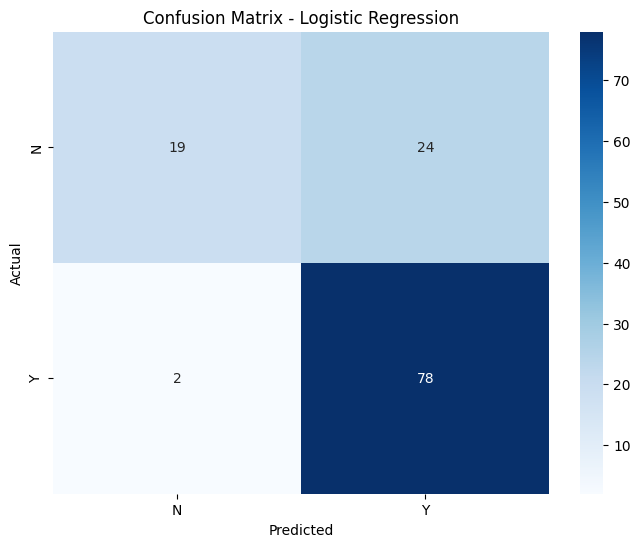

In [132]:
#evaluate the model
print(f"Classification Report:\n{classification_report(y_test, y_pred_logreg)}")

#show a heatmap of TP,TN,FP,FN
plt.figure(figsize=(8, 6))
cm = pd.crosstab(y_test, y_pred_logreg, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


### Decision Tree

In [133]:
decision_tree = DecisionTreeClassifier(random_state=42)

decision_tree.fit(X_train_clean, y_train_clean)
y_pred_tree = decision_tree.predict(X_test)

#### Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           N       0.57      0.47      0.51        43
           Y       0.74      0.81      0.77        80

    accuracy                           0.69       123
   macro avg       0.66      0.64      0.64       123
weighted avg       0.68      0.69      0.68       123



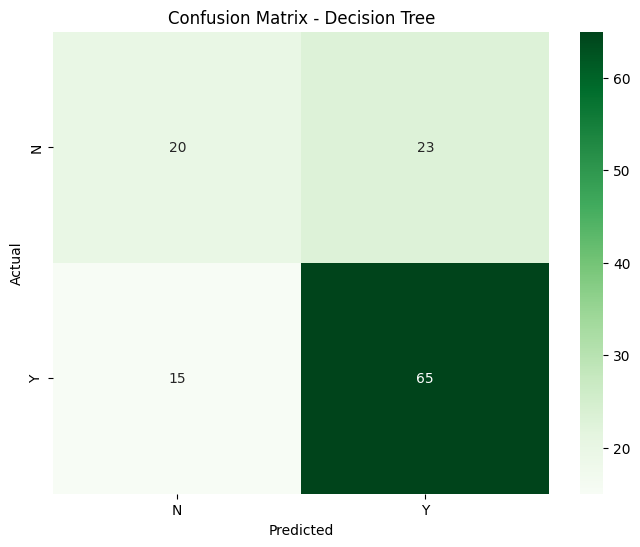

In [134]:
print(f"Classification Report:\n{classification_report(y_test, y_pred_tree)}")

#show a heatmap of TP,TN,FP,FN
plt.figure(figsize=(8, 6))
cm = pd.crosstab(y_test, y_pred_tree, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

### Random Forest

In [135]:
random_forest = RandomForestClassifier(
    max_depth=10,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

random_forest.fit(X_train_clean, y_train_clean)
y_pred_rf = random_forest.predict(X_test)

#### Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           N       0.79      0.51      0.62        43
           Y       0.78      0.93      0.85        80

    accuracy                           0.78       123
   macro avg       0.78      0.72      0.73       123
weighted avg       0.78      0.78      0.77       123



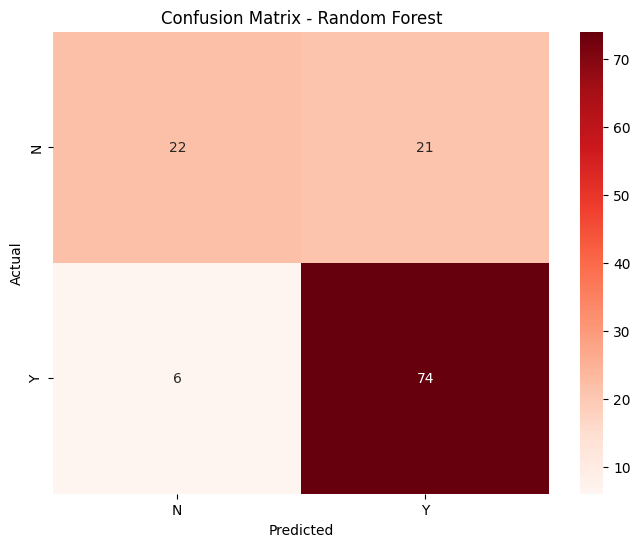

In [136]:
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")

#show a heatmap of TP,TN,FP,FN
plt.figure(figsize=(8, 6))
cm = pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Random Forest')
plt.show()

## Cross-Validation

In [137]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_clean, y_train_clean, cv=5, scoring='accuracy')
    print(f"{name}: Mean CV Accuracy = {scores.mean():.4f} (+/- {scores.std():.4f})")


Logistic Regression: Mean CV Accuracy = 0.8216 (+/- 0.0255)
Decision Tree: Mean CV Accuracy = 0.7337 (+/- 0.0336)
Random Forest: Mean CV Accuracy = 0.8284 (+/- 0.0380)


### Random Forest Optimization

In [138]:
rf = RandomForestClassifier(random_state=42)

# Use a different name to avoid accidental reuse of a previously overwritten variable
rf_param_distributions = {
    "n_estimators": randint(200, 800),         # more trees → more stability
    "max_depth": randint(4, 50),               # regularization
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_distributions,
    n_iter=50,             # 50 random combinations → good balance
    cv=5,
    scoring="accuracy",
    random_state=42,
    verbose=2,
    n_jobs=-1
)

search.fit(X_train_clean, y_train_clean)
print("Best Parameters:", search.best_params_)
print("Best CV Accuracy:", search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'bootstrap': False, 'max_depth': 26, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 298}
Best CV Accuracy: 0.8396578140960163


We will go ahead with logistic regression.

In [139]:
model = LogisticRegression(random_state=0, max_iter=1000)
model.fit(X_train_clean, y_train_clean)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [140]:
y_pred = model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           N       0.90      0.44      0.59        43
           Y       0.76      0.97      0.86        80

    accuracy                           0.79       123
   macro avg       0.83      0.71      0.73       123
weighted avg       0.81      0.79      0.77       123



## Model Explanation

C:\Users\jason\AppData\Roaming\Python\Python313\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


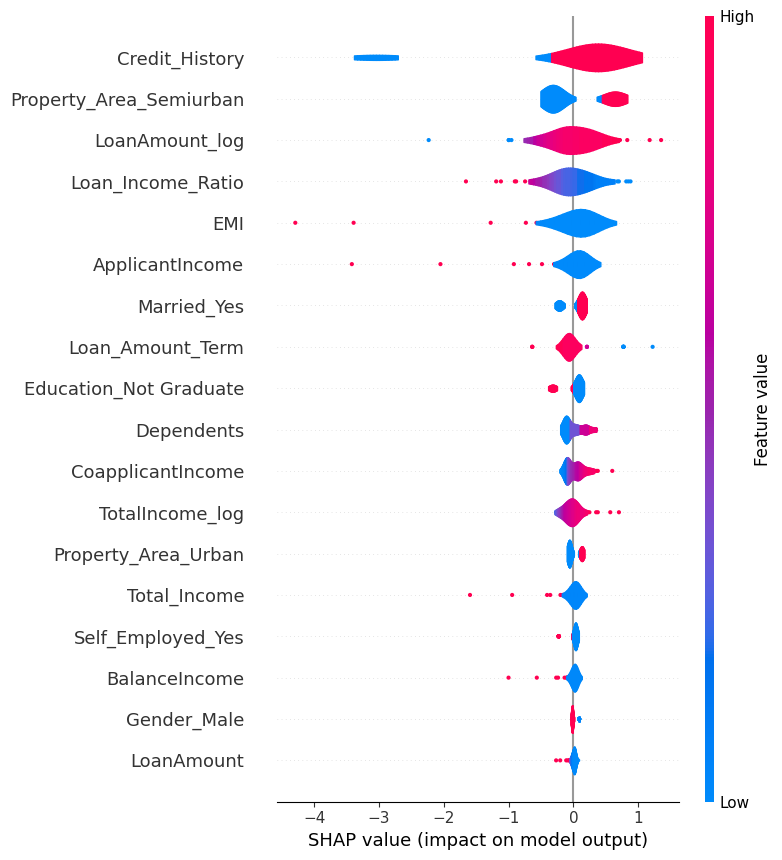

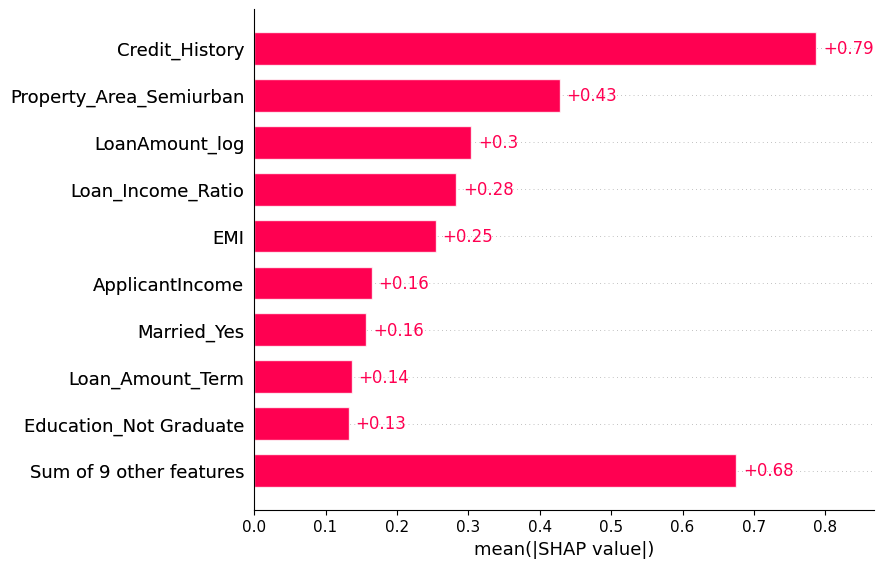

In [141]:
import shap

# Linear Explainer for Logistic Regression
explainer = shap.LinearExplainer(model, X_train_clean, feature_perturbation="interventional")

# Compute SHAP values (returns Explanation object)
shap_values = explainer(X_test)

# Summary plot (violin)
shap.summary_plot(shap_values, X_test, plot_type="violin")

# Bar plot (global feature importance)
shap.plots.bar(shap_values)

# Force plot for first prediction
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0,:])


### SHAP Analysis - Feature Interpretations
1. <b><u>Credit_History (SHAP importance: 0.9)</u></b>
Credit_History is by far the most influential feature, with applicants having good credit history showing strongly positive SHAP values toward approval, while those with poor credit history push strongly toward denial. This feature dominates the model's decision-making, accounting for the majority of prediction impact.

2. <b><u>Property_Area_Semiurban (SHAP importance: 0.41)</u></b>
Properties in semiurban areas generally contribute positively to loan approval, making this the second most important feature. This geographic factor may reflect differences in property values or economic conditions across area types.

3. <b><u>Married_Yes (SHAP importance: 0.22)</u></b>
Married applicants consistently show positive SHAP values, indicating higher likelihood of approval compared to unmarried applicants. The model interprets marital status as a stability indicator, possibly due to dual income potential or perceived financial responsibility.

4. <b><u>Loan_Income_Ratio (SHAP importance: 0.19)</u></b>
Higher loan-to-income ratios produce negative SHAP values pushing toward denial, while lower ratios favor approval. This demonstrates the model appropriately captures debt-to-income considerations as a key risk factor.

5. <b><u>CoapplicantIncome (SHAP importance: 0.14)</u></b>
Higher co-applicant income contributes positively to loan approval by increasing total household resources available for repayment. This feature complements the primary applicant's income in the model's risk assessment.

6. <b><u>Dependents (SHAP importance: 0.14)</u></b>
More dependents tend to produce slightly negative SHAP values as they represent higher household expenses and less disposable income for loan repayment. However, the modest impact suggests the model balances this factor with other income-related features.

7. <b><u>Education_Not Graduate (SHAP importance: 0.12)</u></b>
Non-graduates experience slightly negative impacts while graduates show positive impacts, suggesting the model associates higher education with lower default risk. The small magnitude indicates education is a minor factor in predictions.

8. <b><u>Property_Area_Urban (SHAP importance: 0.10)</u></b>
Urban properties show slight positive tendency toward approval, though the effect is minimal and variable. This suggests property location has some influence but is less significant than other factors.

9. <b><u>LoanAmount (SHAP importance: 0.10)</u></b>
Loan amount shows mixed effects with no clear directional pattern, indicating absolute loan size is less important than contextual factors. Its impact is better captured through Loan_Income_Ratio, which considers affordability relative to income.

10. <b><u>ApplicantIncome</u></b>
Higher applicant income generally produces positive SHAP values favoring approval, though the moderate impact suggests income is most meaningful when combined with other factors. The model considers income holistically alongside loan amount and co-applicant contributions.